In [1]:
import sys
!{sys.executable} -m pip install dash
!{sys.executable} -m pip install jupyter_dash
!{sys.executable} -m pip install dash_boostrap_components

ERROR: Could not find a version that satisfies the requirement dash_boostrap_components (from versions: none)
ERROR: No matching distribution found for dash_boostrap_components


In [2]:
#Importing dependencies
import numpy
import matplotlib.pyplot as plt
import pandas
from jupyter_dash import JupyterDash
import dash
from dash import Dash, dcc, html, dcc, Input, Output, State, dash_table
import plotly.graph_objs as go
import plotly.express as px
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output

In [3]:
#loading in data
#make sure excel sheet is in same directory as jupyter notebook and put path in here
data = pandas.read_excel("ISS_HAL_SOPs_0407.xlsx")

In [4]:
#Doing initial Data Cleaning
HAL = data.iloc[:,3:]
#replacing empty cells with -1 for easier cleaning
HAL = HAL.fillna(-1)
step = []
entity = []
text= []
procedure = []
#Getting final data together
#iterate through rows
for x in range(0,len(HAL)):
    #iterate through columns
    for y in HAL.columns:
        #ensure we're not getting duplicates and only appending non-empty cells
        if HAL.loc[x,y] != -1 and y != 'Procedure File Number' and y != 'Step Number':
            step.append(HAL.loc[x]['Step Number'])
            procedure.append(HAL.loc[x]['Procedure File Number'])
            entity.append(y)
            text.append(HAL.loc[x,y])
            
#Defining a function to combine entitities (e.g Action(What), Action(How), Action(Where) would all fall under ACTION)
def combine(entity):
    if 'Action' in entity:
        return 'ACTION'
    if 'Trigger' in entity:
        return 'TRIGGER'
    if 'Decision' in entity:
        return 'DECISION'
    if 'Waiting' in entity:
        return 'WAITING'
    if 'Verification' in entity:
        return 'VERIFICATION'
#Take data collected and put into dataframe
finalData = pandas.DataFrame(
    {'Procedure': procedure,
     'Step Number': step,
     'Text': text,
     'Entity': entity
    })

#Creating a column so each unique step can index as identified per SOP per Step
finalData['UniqueStep'] = finalData.apply(lambda x: x.Procedure + '_' + str(x['Step Number']),axis=1)
finalData['EntityCombined'] = finalData.Entity.apply(lambda x: combine(x))
stepCounts = {}
finalData
#Creating dictionary to add up different step types
for x in range(0,len(finalData)):
    entity = finalData.loc[x]['EntityCombined']
    if (finalData.loc[x]['UniqueStep'] in stepCounts):
        if entity not in stepCounts[finalData.loc[x]['UniqueStep']]:
            stepCounts[finalData.loc[x]['UniqueStep']].append(entity)
    else:
        stepCounts[finalData.loc[x]['UniqueStep']] = [entity]

#Putting those step types as a column in the dataframe
finalData['Combined Entitities'] = finalData['UniqueStep'].apply(lambda x: ','.join(stepCounts[x]))
finalData

,Procedure,Step Number,Text,Entity,UniqueStep,EntityCombined,Combined Entitities
0,HAL_1_0.pdf,1,Stow monitors against the wall,Action (What),HAL_1_0.pdf_1,ACTION,ACTION
1,HAL_1_0.pdf,2,Stow the keyboards against the wall,Action (What),HAL_1_0.pdf_2,ACTION,ACTION
2,HAL_1_0.pdf,3,Remove the seat cushion,Action (What),HAL_1_0.pdf_3,ACTION,ACTION
3,HAL_1_0.pdf,4,Fold the chair backs forward,Action (What),HAL_1_0.pdf_4,ACTION,ACTION
4,HAL_1_0.pdf,5,Detach crew hygiene kit,Action (What),HAL_1_0.pdf_5,ACTION,ACTION
...,...,...,...,...,...,...,...
1180,HAL_5_999.pdf,50,"Select ""Close SAL Door""",Action (What),HAL_5_999.pdf_50,ACTION,"TRIGGER,ACTION,VERIFICATION"
1181,HAL_5_999.pdf,50,when finished,Verification (What),HAL_5_999.pdf_50,VERIFICATION,"TRIGGER,ACTION,VERIFICATION"
1182,HAL_5_999.pdf,50,turns blue,Verification (How),HAL_5_999.pdf_50,VERIFICATION,"TRIGGER,ACTION,VERIFICATION"
1183,HAL_5_999.pdf,50,bottom,Verification (Where),HAL_5_999.pdf_50,VERIFICATION,"TRIGGER,ACTION,VERIFICATION"


In [5]:
#Gathering the statistics requested from partner for each Step Type
def stepClassify(x):
    if x == 'ACTION':
        return 'ACTION-ONLY'
    if x == 'DECISION,ACTION' or x == 'ACTION,DECISION':
        return 'DECISION-ACTION'
    if ('ACTION' in x) & ('WAITING' in x) & ('VERIFICATION' in x) & ('DECISION' not in x):
        return 'ACTION with WAITING & VERIFICATION'
    if ('ACTION' in x) & ('WAITING' in x) & ('VERIFICATION' in x) & ('DECISION' in x):
        return 'DECISION-ACTION with WAITING & VERIFICATION'

finalData['StepType'] = finalData['Combined Entitities'].apply(lambda x: stepClassify(x))
summary = pandas.DataFrame(finalData.groupby(['StepType','Entity']).StepType.count())
finalData

,Procedure,Step Number,Text,Entity,UniqueStep,EntityCombined,Combined Entitities,StepType
0,HAL_1_0.pdf,1,Stow monitors against the wall,Action (What),HAL_1_0.pdf_1,ACTION,ACTION,ACTION-ONLY
1,HAL_1_0.pdf,2,Stow the keyboards against the wall,Action (What),HAL_1_0.pdf_2,ACTION,ACTION,ACTION-ONLY
2,HAL_1_0.pdf,3,Remove the seat cushion,Action (What),HAL_1_0.pdf_3,ACTION,ACTION,ACTION-ONLY
3,HAL_1_0.pdf,4,Fold the chair backs forward,Action (What),HAL_1_0.pdf_4,ACTION,ACTION,ACTION-ONLY
4,HAL_1_0.pdf,5,Detach crew hygiene kit,Action (What),HAL_1_0.pdf_5,ACTION,ACTION,ACTION-ONLY
...,...,...,...,...,...,...,...,...
1180,HAL_5_999.pdf,50,"Select ""Close SAL Door""",Action (What),HAL_5_999.pdf_50,ACTION,"TRIGGER,ACTION,VERIFICATION",None
1181,HAL_5_999.pdf,50,when finished,Verification (What),HAL_5_999.pdf_50,VERIFICATION,"TRIGGER,ACTION,VERIFICATION",None
1182,HAL_5_999.pdf,50,turns blue,Verification (How),HAL_5_999.pdf_50,VERIFICATION,"TRIGGER,ACTION,VERIFICATION",None
1183,HAL_5_999.pdf,50,bottom,Verification (Where),HAL_5_999.pdf_50,VERIFICATION,"TRIGGER,ACTION,VERIFICATION",None


In [6]:
#Calculating totals of each StepType
totals = []
#Each possible step type
types = ['ACTION-ONLY', 'DECISION-ACTION', 'ACTION with WAITING & VERIFICATION', 'DECISION-ACTION with WAITING & VERIFICATION', 'OTHER', 'ALL']
#Find the number of each Step Type for each unique step
totals.append(len(finalData[finalData.StepType == 'ACTION-ONLY'].UniqueStep.unique()))
totals.append(len(finalData[finalData.StepType == 'DECISION-ACTION'].UniqueStep.unique()))
totals.append(len(finalData[finalData.StepType == 'ACTION with WAITING & VERIFICATION'].UniqueStep.unique()))
totals.append(len(finalData[finalData.StepType == 'DECISION-ACTION with WAITING & VERIFICATION'].UniqueStep.unique()))
totals.append(len(finalData.UniqueStep.unique()) - sum(totals))
totals.append(len(finalData.UniqueStep.unique()))
#Create a dataframe to hold that data
stepTotals = pandas.DataFrame({'Step Types': types, 'Count': totals})
#Calculate the percent from the counts to two decimal points
stepTotals['Percent of Total'] = round((stepTotals.Count/(stepTotals['Count'][5]))*100,2)
stepTotals

,Step Types,Count,Percent of Total
0,ACTION-ONLY,187,42.89
1,DECISION-ACTION,9,2.06
2,ACTION with WAITING & VERIFICATION,10,2.29
3,DECISION-ACTION with WAITING & VERIFICATION,0,0.00
4,OTHER,230,52.75
5,ALL,436,100.00


In [7]:
#Calculating the percentage of each entity type
#Calculate the total number of unique steps
totalSteps = len(finalData.UniqueStep.unique())
#Creating a list of each unique Entity 
entityTypes = list(finalData.Entity.unique())
#Added these two entitities in as they were not apparent in this dataset, can comment out if apparent in newer datasets
entityTypes.append('Decision (Where)')
entityTypes.append('Decision (How)')
entityTypes.sort()
entityTypes
totalEntityTypes = []
#calculating the counts of each unique entity
for x in entityTypes:
    totalEntityTypes.append(len(finalData[finalData.Entity == x]))
#put data in dataframe
entitySummary = pandas.DataFrame({'Entity': entityTypes, 'Count': totalEntityTypes})
entitySummary['Percent'] = round((entitySummary.Count/totalSteps)*100,2)
entitySummary

,Entity,Count,Percent
0,Action (How),9,2.06
1,Action (What),436,100.00
2,Action (Where),148,33.94
3,Decision (How),0,0.00
4,Decision (What),9,2.06
5,Decision (Where),0,0.00
6,Trigger (How),179,41.06
7,Trigger (What),15,3.44
8,Trigger (Where),201,46.10
9,Verification (How),70,16.06


<ipython-input-8-e339550ee4f1>:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.text(i, y[i] + 2,str(y[i]) + '%', ha = 'center',


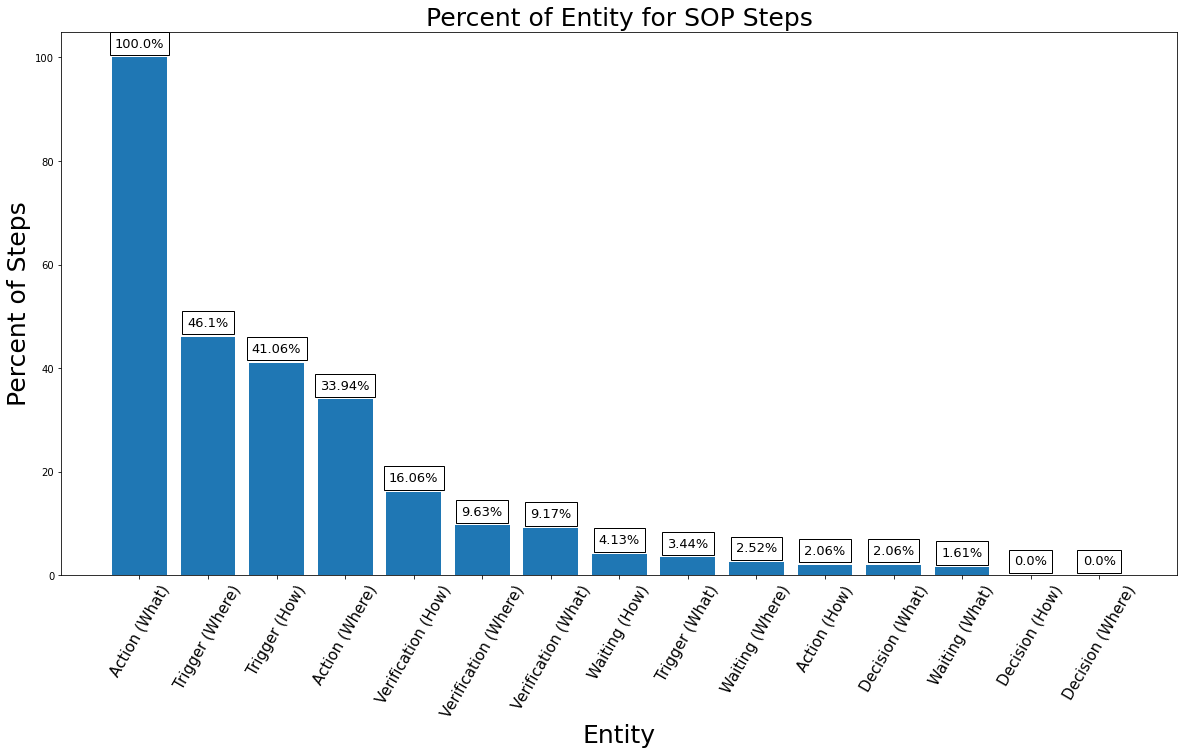

In [8]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i] + 2,str(y[i]) + '%', ha = 'center',
                 Bbox = dict(facecolor = 'white'),size=13)
    
# creating data on which bar chart will be plot
x = list(entitySummary.sort_values('Percent', ascending=False).Entity)
y = list(entitySummary.sort_values('Percent', ascending=False).Percent)

# setting figure size by using figure() function
plt.figure(figsize = (20, 10))

# making the bar chart on the data
plt.bar(x, y)

# calling the function to add value labels
addlabels(x, y)

# giving title to the plot
plt.title("Percent of Entity for SOP Steps", fontsize=25)

# giving X and Y labels
plt.xlabel("Entity", fontsize=25)
plt.ylabel("Percent of Steps", fontsize=25)
plt.xticks(rotation=60, fontsize=15)
# visualizing the plot
plt.show()

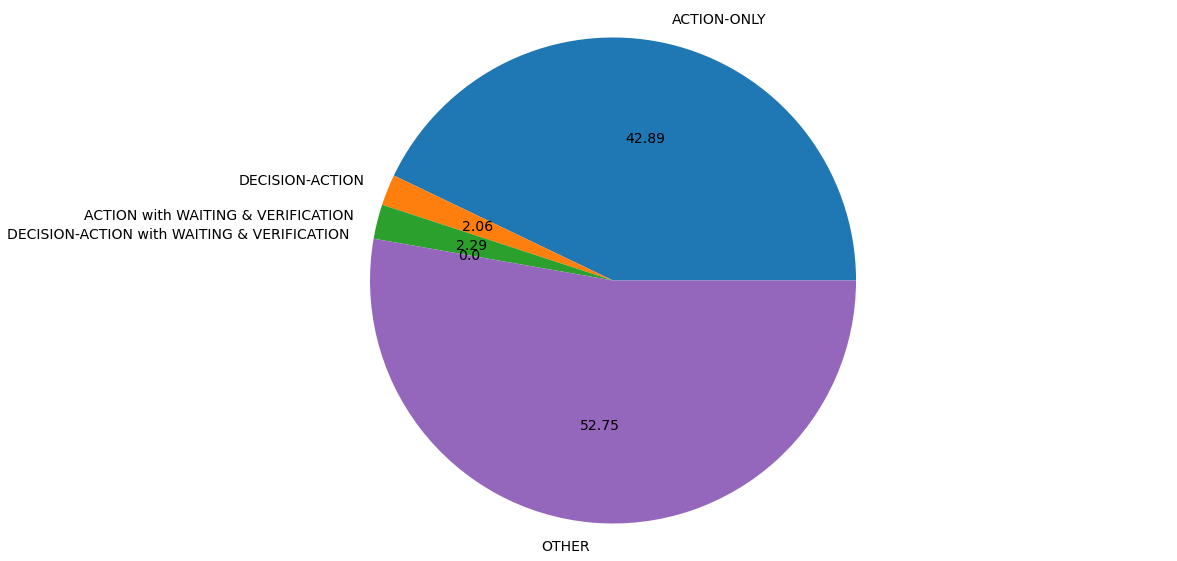

In [9]:
#initial figure creation
plt.figure(figsize = (20, 10))
#getting relevant data from dataframe
pieData = stepTotals.iloc[:5]['Count']
#getting the labels for parts of the pie chart
labels = stepTotals.iloc[:5]['Step Types']
labels
#Plotting out the data
p, tx, autotexts = plt.pie(pieData, labels=labels, autopct='', textprops={'fontsize': 14})
for i, a in enumerate(autotexts):
    a.set_text("{}".format(round(stepTotals.iloc[:5]['Percent of Total'][i],2)))

plt.axis('equal')
plt.show()

In [10]:

#Getting a copy of each relevant dataframe
df = finalData.copy()
#utilizing only these 5 columns from the data, can add more if wanted by adding to this list
df = df[['Procedure', 'Step Number', 'Text', 'Entity', 'StepType']]
df1 = entitySummary.copy()
df2 = stepTotals.copy()


#Creates the interactive dashboard
app = JupyterDash(__name__)

app.layout = dbc.Container([
    #Three dropdowns for filters
    dbc.Label('Show Number of Rows'),   
    row_drop := dcc.Dropdown(value=10, clearable=False, options=[10,25,50], id='row_drop', style={'width': '35%'}),
    dbc.Label('Procedure Name'),
    procedure_drop := dcc.Dropdown([x for x in sorted(df.Procedure.unique())], id='procedure-dropdown',multi=True, style={'width': '35%'}),   
    dbc.Label('Step Type'),
    step_drop := dcc.Dropdown([x for x in stepTotals['Step Types'][:5]], id='step-dropdown', style={'width': '35%'}),
    
    
    #finalData Table
    my_table := dash_table.DataTable(
        columns=[
            {"name": i, "id": i} for i in df.columns
        ],
        data=df.to_dict('records'),
        page_size= 10,
    ),
    
    
    
    #dropdown for step type filtering
    dcc.Markdown('# Percent of Entitities', style={'textAlign': 'center'}),
    dbc.Label('Step Type'),
    summary_step_drop := dcc.Dropdown([x for x in stepTotals['Step Types'][:5]], id='summary-step-dropdown', style={'width': '35%'}),

    #Creating the table for entitySummary
    summary_table := dash_table.DataTable(
        columns=[
            {"name": i, "id": i} for i in df1.columns
        ],
        data=df1.to_dict('records')
    ),
    
    #Creating bar chart for entitySummary
    dcc.Graph(
    figure={
        'data': [
            {'x': list(df1.sort_values('Percent', ascending=False).Entity),
             'y': list(df1.sort_values('Percent', ascending=False).Percent),
             'type': 'bar'},
        ],
        'layout': {
            'title': 'Dash Data Visualization'
        }
    }
,id="bar-graph"),
    
    #Dropdown for procedure name
    dcc.Markdown('# Percent of Step Types', style={'textAlign': 'center'}),
    dbc.Label('Procedure Name'),
    pie_procedure_drop := dcc.Dropdown([x for x in sorted(df.Procedure.unique())], id='pie-procedure-dropdown',multi=True, style={'width': '35%'}),
    
    
    #Create table for stepTypes
    step_table := dash_table.DataTable(
    columns=[
            {"name": i, "id": i} for i in df2.columns
        ],
        data=df2.to_dict('records')
    ),
    
    
    #Create PieChart for stepTypes
    dcc.Graph(id='Pie-Chart')
], fluid=True)

#Outputs and inputs for initial finalData table
#my_table is the table figure
#page_size is the number of rows to show
#procedure-dropdown are the procedures to filter on
#row_drop are the number of rows to display to filter on
#step-dropdown are the step-types to filter on
@app.callback(
    Output(my_table, 'data'),
    Output(my_table,'page_size'),
    Input('procedure-dropdown', 'value'),
    Input('row_drop', 'value'),
    Input('step-dropdown', 'value'),
)

#Function updating the finalData table based on filters
def update_output(procedure, row_size, step):
    #Creates a copy of the initial talbe
    dff = df.copy()
    #If procedures are designated in dropdown filter filter on them
    if procedure:
        dff = dff[dff.Procedure.isin(procedure)]
        totalSteps = len(finalData.UniqueStep.unique())
        totalEntityTypes = []
    #If stepType is designated in dropdown filter filter on them
    if step:
        dff = dff[dff.StepType == step]
    #return the filtered table and number of rows
    return dff.to_dict('records'), row_size


#Outputs and inputs for initial entitySummary table
#summary_table is the table figure
#page_size is the number of rows to show
#bar graph is the figure to return
#summary-step-dropdown are the step-types to filter on
@app.callback(
    Output(summary_table, 'data'),
    Output(summary_table, 'page_size'),
    Output('bar-graph', 'figure'),
    Input('summary-step-dropdown', 'value')
)
#Function to update bar chart and entitySummary table 
def update_bar(summaryStep):
    #Create table to filter on
    filterData = finalData.copy()
    #Grabbing the Step Types
    entityStepTypes = ['ACTION-ONLY', 'DECISION-ACTION', 'ACTION with WAITING & VERIFICATION', 'DECISION-ACTION with WAITING & VERIFICATION']
    #If stepType designated in dropdown filter on it
    if summaryStep:
        #If OTHER is selected filter on all data not in entityStepTypes list
        if summaryStep == "OTHER":
            filterData = finalData[~finalData.StepType.isin(entityStepTypes)]
        #Otherwise filter on StepType selected
        else:    
            filterData = finalData[finalData.StepType == summaryStep]
    #Calculate new StepType Totals
    filterEntityTypeTotals = []
    filterTotalSteps = len(filterData.UniqueStep.unique())
    for x in entityTypes:
        filterEntityTypeTotals.append(len(filterData[filterData.Entity == x]))
    #Create the dataframe to return
    dff1 = pandas.DataFrame({'Entity': entityTypes, 'Count': filterEntityTypeTotals})
    dff1['Percent'] = round((dff1.Count/filterTotalSteps)*100,2)
    #return the table and updated bar chart
    return dff1.sort_values('Percent', ascending=False).to_dict('records'), 15, {'data': [go.Bar(
        x=list(dff1.sort_values('Percent', ascending=False).Entity),
        y=list(dff1.sort_values('Percent', ascending=False).Percent)
        )]
        }


#Outputs and inputs for initial finalData table
#step_table is the table figure
#page_size is the number of rows to show
#pie-procedure-dropdown are the procedures to filter on
#Pie-Chart is the PieChart figure to return
@app.callback(
    Output(step_table, 'data'),
    Output(step_table, 'page_size'),
    Output('Pie-Chart', 'figure'),
    Input('pie-procedure-dropdown', 'value')
)
#function to update stepType table and PieChart
def update_pie(pieDrop):
    #Get clean copy of table
    dff2 = df2.copy()
    #Filter given procedure dropdown value
    if pieDrop:
        filterTotals = []
        #Filter on the procedures selected
        filterData = finalData[finalData.Procedure.isin(pieDrop)]
        #calculate the totals
        filterTotals.append(len(filterData[filterData.StepType == 'ACTION-ONLY'].UniqueStep.unique()))
        filterTotals.append(len(filterData[filterData.StepType == 'DECISION-ACTION'].UniqueStep.unique()))
        filterTotals.append(len(filterData[filterData.StepType == 'ACTION with WAITING & VERIFICATION'].UniqueStep.unique()))
        filterTotals.append(len(filterData[filterData.StepType == 'DECISION-ACTION with WAITING & VERIFICATION'].UniqueStep.unique()))
        filterTotals.append(len(filterData.UniqueStep.unique()) - sum(filterTotals))
        filterTotals.append(len(filterData.UniqueStep.unique()))
        #Create the dataframe to return
        dff2 = pandas.DataFrame({'Step Types': types, 'Count': filterTotals})
        dff2['Percent of Total'] = round((dff2.Count/(dff2['Count'][5]))*100,2)
    #create an updated pie chart
    piechart = px.pie(data_frame=dff2[:5],
                      values='Percent of Total',
                     names='Step Types')
    #return the table and piechart
    return dff2[:5].to_dict('records'), 5, piechart

#runs the dashboard
if __name__ == '__main__':
    app.run_server(debug=True)
#click on ip address below to see the dashboard

Dash is running on http://127.0.0.1:8050/

Dash app running on http://127.0.0.1:8050/
